In [1]:
## Mount drive:

from google.colab import drive
drive.mount('/content/gdrive')

## head to drive:

%cd '/content/gdrive/My Drive/Traffic_Light_Detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Traffic_Light_Detection


# 2. Install required dependencies to run TensorFlow Object Detection API

In [0]:
## Install required dependencies for colab:

!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

%cd /content/gdrive/My Drive/Traffic_Light_Detection/models/research/
!protoc object_detection/protos/*.proto --python_out=.




In [0]:
## Set up the environment
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/Traffic_Light_Detection/models/research/:/content/gdrive/My Drive/Traffic_Light_Detection/models/research/slim'


# 3. Run setup script and make sure it pass model_builder_test

In [0]:
# Setup script:

# note must be at models/research
!python setup.py build
!python setup.py install

# at research/object_detection ~~~: check whether is everything set up properly
!python object_detection/builders/model_builder_test.py

# 4. Add pycocotools as the model that will be used are trained on the COCO Dataset

In [0]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI 
!make
!cp -R ./pycocotools /content/gdrive/My\ Drive/Traffic_Light_Detection/models/research/

# 5. Train the model

Necessary steps before training:

0. Download the utilities files for the Object Detection API [HERE](https://github.com/tensorflow/models)

- I created a file name Traffic_Light_Detection and git clone the link.

1. Gathering and labelling images. For labelling, check out this free labelling program: [HERE](https://github.com/tzutalin/labelImg). LabelImg provides you with XML files for images that you annotate. Split your images and store into respective directories of `train` and `test`. 

2. Convert XML files to CSV, use xml_to_csv.py from [HERE](https://github.com/timothylimyl/Custom-Traffic-Light-State-Detector)

3. The csv files for both testing and training has to been converted into a TFRecord file. Use generate_tfrecord.py from [HERE](https://github.com/timothylimyl/Custom-Traffic-Light-State-Detector). Remember to go into script and edit the labels accordingly.

- TFRecord connects the images to its label for the network. I am storing this at  ...../research/object_detection

4. Now we will need a pre-trained network for transfer learning, head over to Tensorflow model detection zoo [HERE](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Download the model that you wish to use (git clone link)


5. In the model file, you will see model-ckpt which is the checkpoint of the network that we fine tune on for our purpose. The file also contains the configurations of the network which is a  .config file. ***Edit the config file, change the 1) number of classes 2) path to your model checkpoint (directory where you git clone the link given at Step 4. 3) path to your training and testing dataset.*** Place this edited config file into your training directory (I called mine: `training`)

6. Create a label map pbtxt file, example [HERE](https://github.com/timothylimyl/Custom-Traffic-Light-State-Detector). Put it into the file `training`.

- `training` file contains label_map.pbtxt and your_desired_model.config



*ALL the links I have provided is all you would require to build your own custom object detector!

In [0]:
## Look at how you set up your file, my images and training is in object_detection/
%cd 
%cd /content/gdrive/My Drive/Traffic_Light_Detection/models/research/object_detection

## Now that in config file, you are in object_detection file now when creating paths:

#SSD:

!python model_main.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_mobilenet_v2_coco.config


#Faster-RCNN:

#!python3 model_main.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

# 6. Export your custom made model into an inference graph 

In [0]:
%cd
%cd /content/gdrive/My\ Drive/Traffic_Light_Detection/models/research/object_detection/

# RCNN:
'''
!python export_inference_graph.py \
--input_type image_tensor \
--pipeline_config_path training/faster_rcnn_inception_v2_pets.config \
--trained_checkpoint_prefix /tmp/tmp5zae1mg8/model.ckpt-20000 \
--output_directory rcnn_custom_graph/

'''

# SSD:


!python export_inference_graph.py \
--input_type image_tensor \
--pipeline_config_path training/ssd_mobilenet_v2_coco.config \
--trained_checkpoint_prefix /tmp/tmpfvtaigwd/model.ckpt-25000 \
--output_directory ssd_custom_graph_2/


In [31]:

!zip -r ssd_custom_graph_2.zip ssd_custom_graph_2


updating: ssd_custom_graph_2/ (stored 0%)
  adding: ssd_custom_graph_2/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: ssd_custom_graph_2/model.ckpt.index (deflated 69%)
  adding: ssd_custom_graph_2/checkpoint (deflated 42%)
  adding: ssd_custom_graph_2/model.ckpt.meta (deflated 94%)
  adding: ssd_custom_graph_2/frozen_inference_graph.pb (deflated 10%)
  adding: ssd_custom_graph_2/saved_model/ (stored 0%)
  adding: ssd_custom_graph_2/saved_model/variables/ (stored 0%)
  adding: ssd_custom_graph_2/saved_model/saved_model.pb (deflated 10%)
  adding: ssd_custom_graph_2/pipeline.config (deflated 69%)


# 7. Testing your model and celebrate! :D

In [0]:
MODEL_NAME = 'ssd_custom_graph_2'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/label_map.pbtxt'
NUM_CLASSES = 3 #remember number of objects you are training? cool.

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

from PIL import Image
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from utils import label_map_util
from utils import visualization_utils as vis_util




#### Loading frozen network:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


#Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.png'.format(i)) for i in range(10, 14) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)



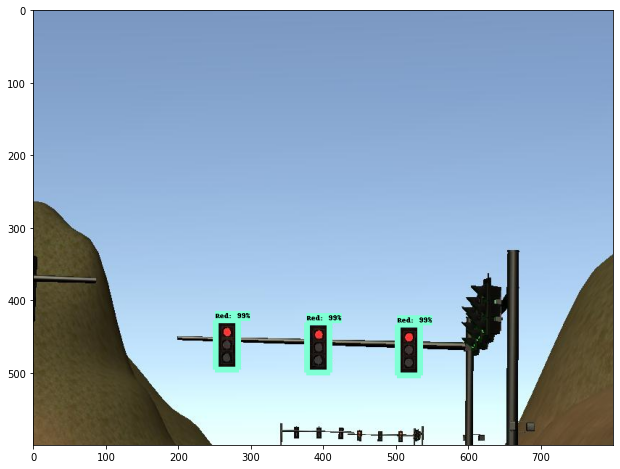

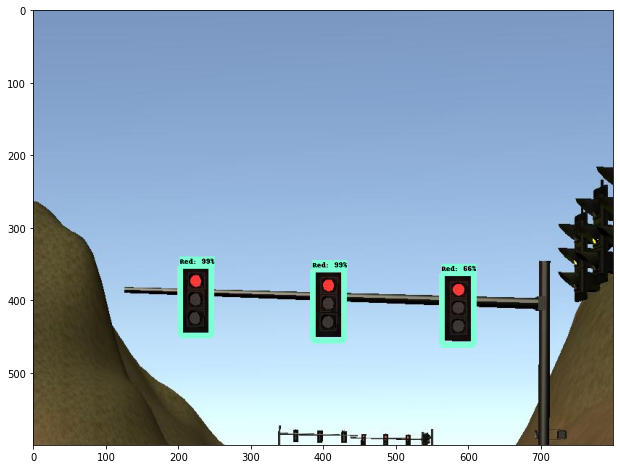

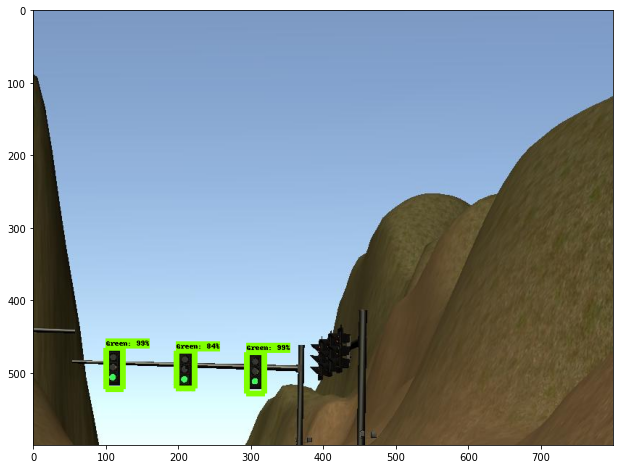

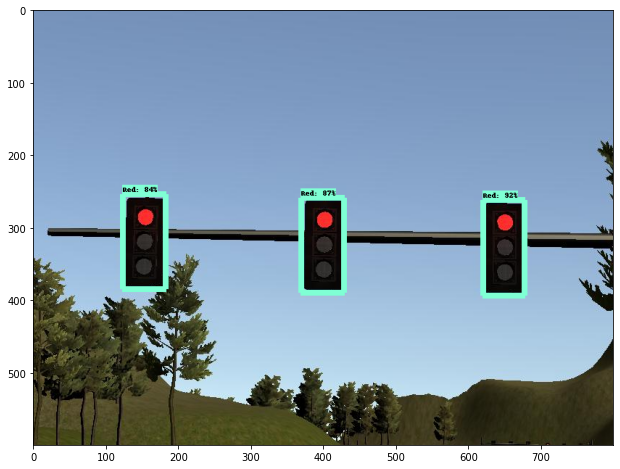

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:

    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)